<div align="center">
    <h1>Aprendizaje automático</h1>
    <h3>Fundamentos y aplicaciones en meteorología del espacio</h3>
    <h4>TP 1: Clasificación</h4>
     <h5>Alumno: Federico Iza</h5>
</div>

# CMEs Classification

In [1]:
import pandas as pd
from tp1_cmes_settings import *
import matplotlib.pyplot as plt
from utils.plot import config_plots
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers.core import Dense
import tensorflow as tf

2022-08-11 13:00:44.604107: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-11 13:00:44.604127: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%matplotlib inline
config_plots()

## Data Acquisition

In [26]:
df = pd.read_csv('../data/CMEs.csv')
df.rename(columns={'vprop': 'Velocity'}, inplace=True)

In [27]:
df.describe()

,Velocity
count,65.000000
mean,718.676923
std,402.923849
min,232.000000
25%,409.000000
50%,592.000000
75%,937.000000
max,1968.000000


## Data Pre-processing

In [28]:
# Numerical data has to be used in ANNs
numerical_origin = {'flare': 1, 'no flare': 0}
df['Origin'] = df['Origin'].map(numerical_origin)

numerical_activity = {'low': 0, 'high': 1}
df['SunActivity'] = df['SunActivity'].map(numerical_activity)

In [29]:
df.describe()

,SunActivity,Velocity,Origin
count,65.000000,65.000000,65.00000
mean,0.661538,718.676923,0.60000
std,0.476869,402.923849,0.49371
min,0.000000,232.000000,0.00000
25%,0.000000,409.000000,0.00000
50%,1.000000,592.000000,1.00000
75%,1.000000,937.000000,1.00000
max,1.000000,1968.000000,1.00000


In [30]:
np.sum(df == np.nan)

SunActivity    0
Velocity       0
Origin         0
dtype: int64

## Feature Engineering

### Data Balance

In [31]:
data_balace = df['Origin'].value_counts()
print(data_balace)

1    39
0    26
Name: Origin, dtype: int64


In [32]:
# Remove data to balance dataset
counter = 13  # Remove the first 99 rows with target=1
df_aux = pd.DataFrame()
for idx, row in df.iterrows():
    if counter > 0:
        if row['Origin'] == 1:
            counter -= 1
        else:
            df_aux = pd.concat([df_aux, pd.DataFrame(row).T],
                               axis=0,
                               ignore_index=True)
    else:
        df_aux = pd.concat([df_aux, pd.DataFrame(row).T],
                           axis=0,
                           ignore_index=True)

In [33]:
data_balace = df_aux['Origin'].value_counts()
print(data_balace)

1    26
0    26
Name: Origin, dtype: int64


In [34]:
df_aux.describe()

,SunActivity,Velocity,Origin
count,52.000000,52.000000,52.000000
mean,0.653846,697.346154,0.500000
std,0.480384,395.119485,0.504878
min,0.000000,232.000000,0.000000
25%,0.000000,408.500000,0.000000
50%,1.000000,551.500000,0.500000
75%,1.000000,880.750000,1.000000
max,1.000000,1968.000000,1.000000


## Data Preparation

In [35]:
features = df_aux.loc[:, df_aux.columns != 'Origin'].copy()
target =  df_aux.loc[:, df_aux.columns == 'Origin'].copy()

In [36]:
features

,SunActivity,Velocity
0,0,1968
1,0,1173
2,0,1600
3,0,1089
4,0,453
5,1,1152
6,1,790
7,1,937
8,1,552
9,1,963


In [37]:
# Scaling analysis (if necessary)
print(features.min(), features.max())

SunActivity      0
Velocity       232
dtype: int64 SunActivity       1
Velocity       1968
dtype: int64


In [38]:
scaler = MinMaxScaler()
features.loc[:, 'Velocity'] = scaler.fit_transform(
    np.array(features['Velocity']).reshape(-1, 1))

In [39]:
features

,SunActivity,Velocity
0,0,1.000000
1,0,0.542051
2,0,0.788018
3,0,0.493664
4,0,0.127304
5,1,0.529954
6,1,0.321429
7,1,0.406106
8,1,0.184332
9,1,0.421083


In [40]:
# Scaling analysis (if necessary)
print(features.min(), features.max())

SunActivity    0.0
Velocity       0.0
dtype: float64 SunActivity    1.0
Velocity       1.0
dtype: float64


## Modeling

In [41]:
(feats_train, feats_test,
 target_train, target_test) = train_test_split(features, target,
                                               test_size=TEST_SIZE)

In [42]:
input_size = feats_train.shape[1]  # Number of feat for training
print(input_size)

2


In [43]:
# ANN architecture
model = Sequential()  # Instance the model

for i in range(N_LAYERS['cmes']):  # Add layers
    model.add(Dense(units=N_NEURONS['cmes'][i],  # Specify number of neurons
                    input_dim=input_size))  # Specify input size
    model.add(Activation(ACTIVATION_FUNCTIONS['cmes'][i]))  # Add activation funcs

# Complile model
model.compile(loss=LOSS_FUNCTION,  # Select loss function
              optimizer=OPTIMIZER,  # Select optimizer
              metrics=[tf.keras.metrics.Accuracy()],  # Select metrics
              )

In [44]:
history = model.fit(feats_train, target_train,
                    epochs=N_EPOCHS['cmes'],
                    validation_split=VALIDATION_SPLIT,
                    verbose=0)

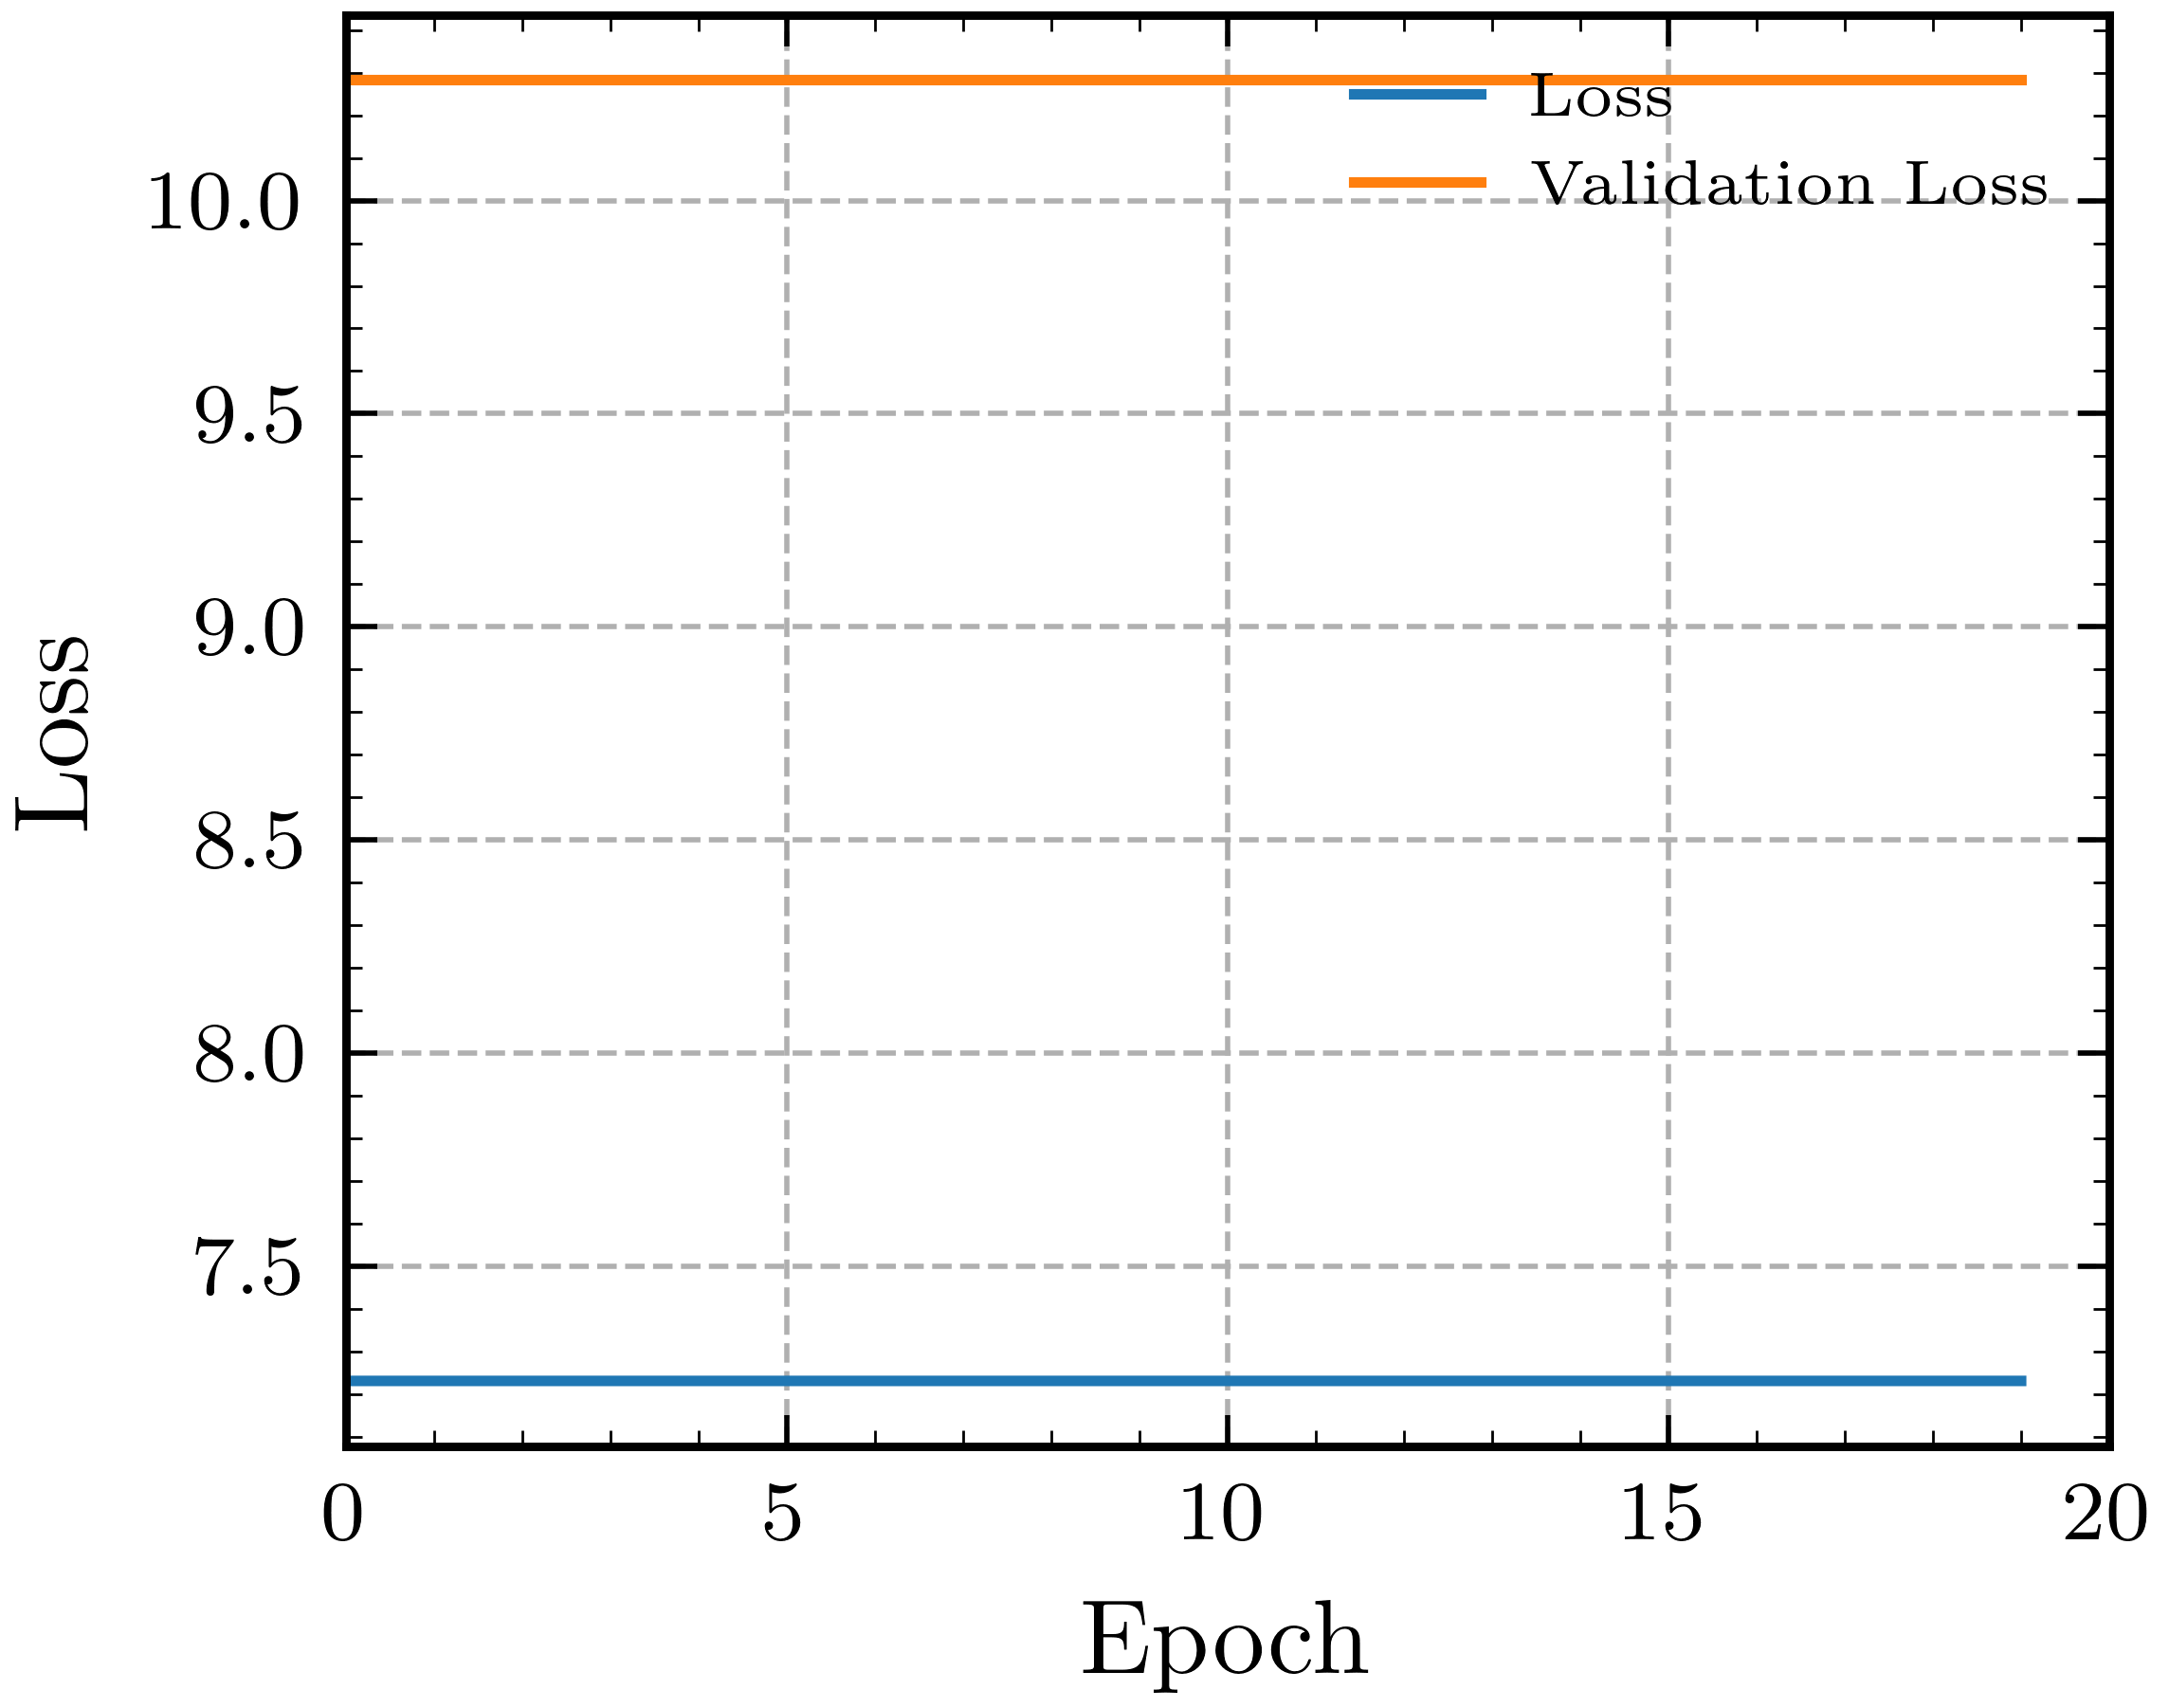

In [45]:
fig = plt.figure(facecolor='white')
gs = fig.add_gridspec(ncols=1, nrows=1, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)

ax.label_outer()
ax.tick_params(which='both', direction="in")
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', lw=.5)
ax.minorticks_on()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_xlim(0, N_EPOCHS['cmes'])
# ax.set_ylim(0, 5)

ax.plot(history.history['loss'], color='tab:blue',
        ls='-', lw=1, label='Loss')
ax.plot(history.history['val_loss'], color='tab:orange',
        ls='-',  lw=1, label='Validation Loss')

ax.legend(loc='upper right', framealpha=0)
fig.savefig('../images/tp1_fig3.pdf')
plt.show()

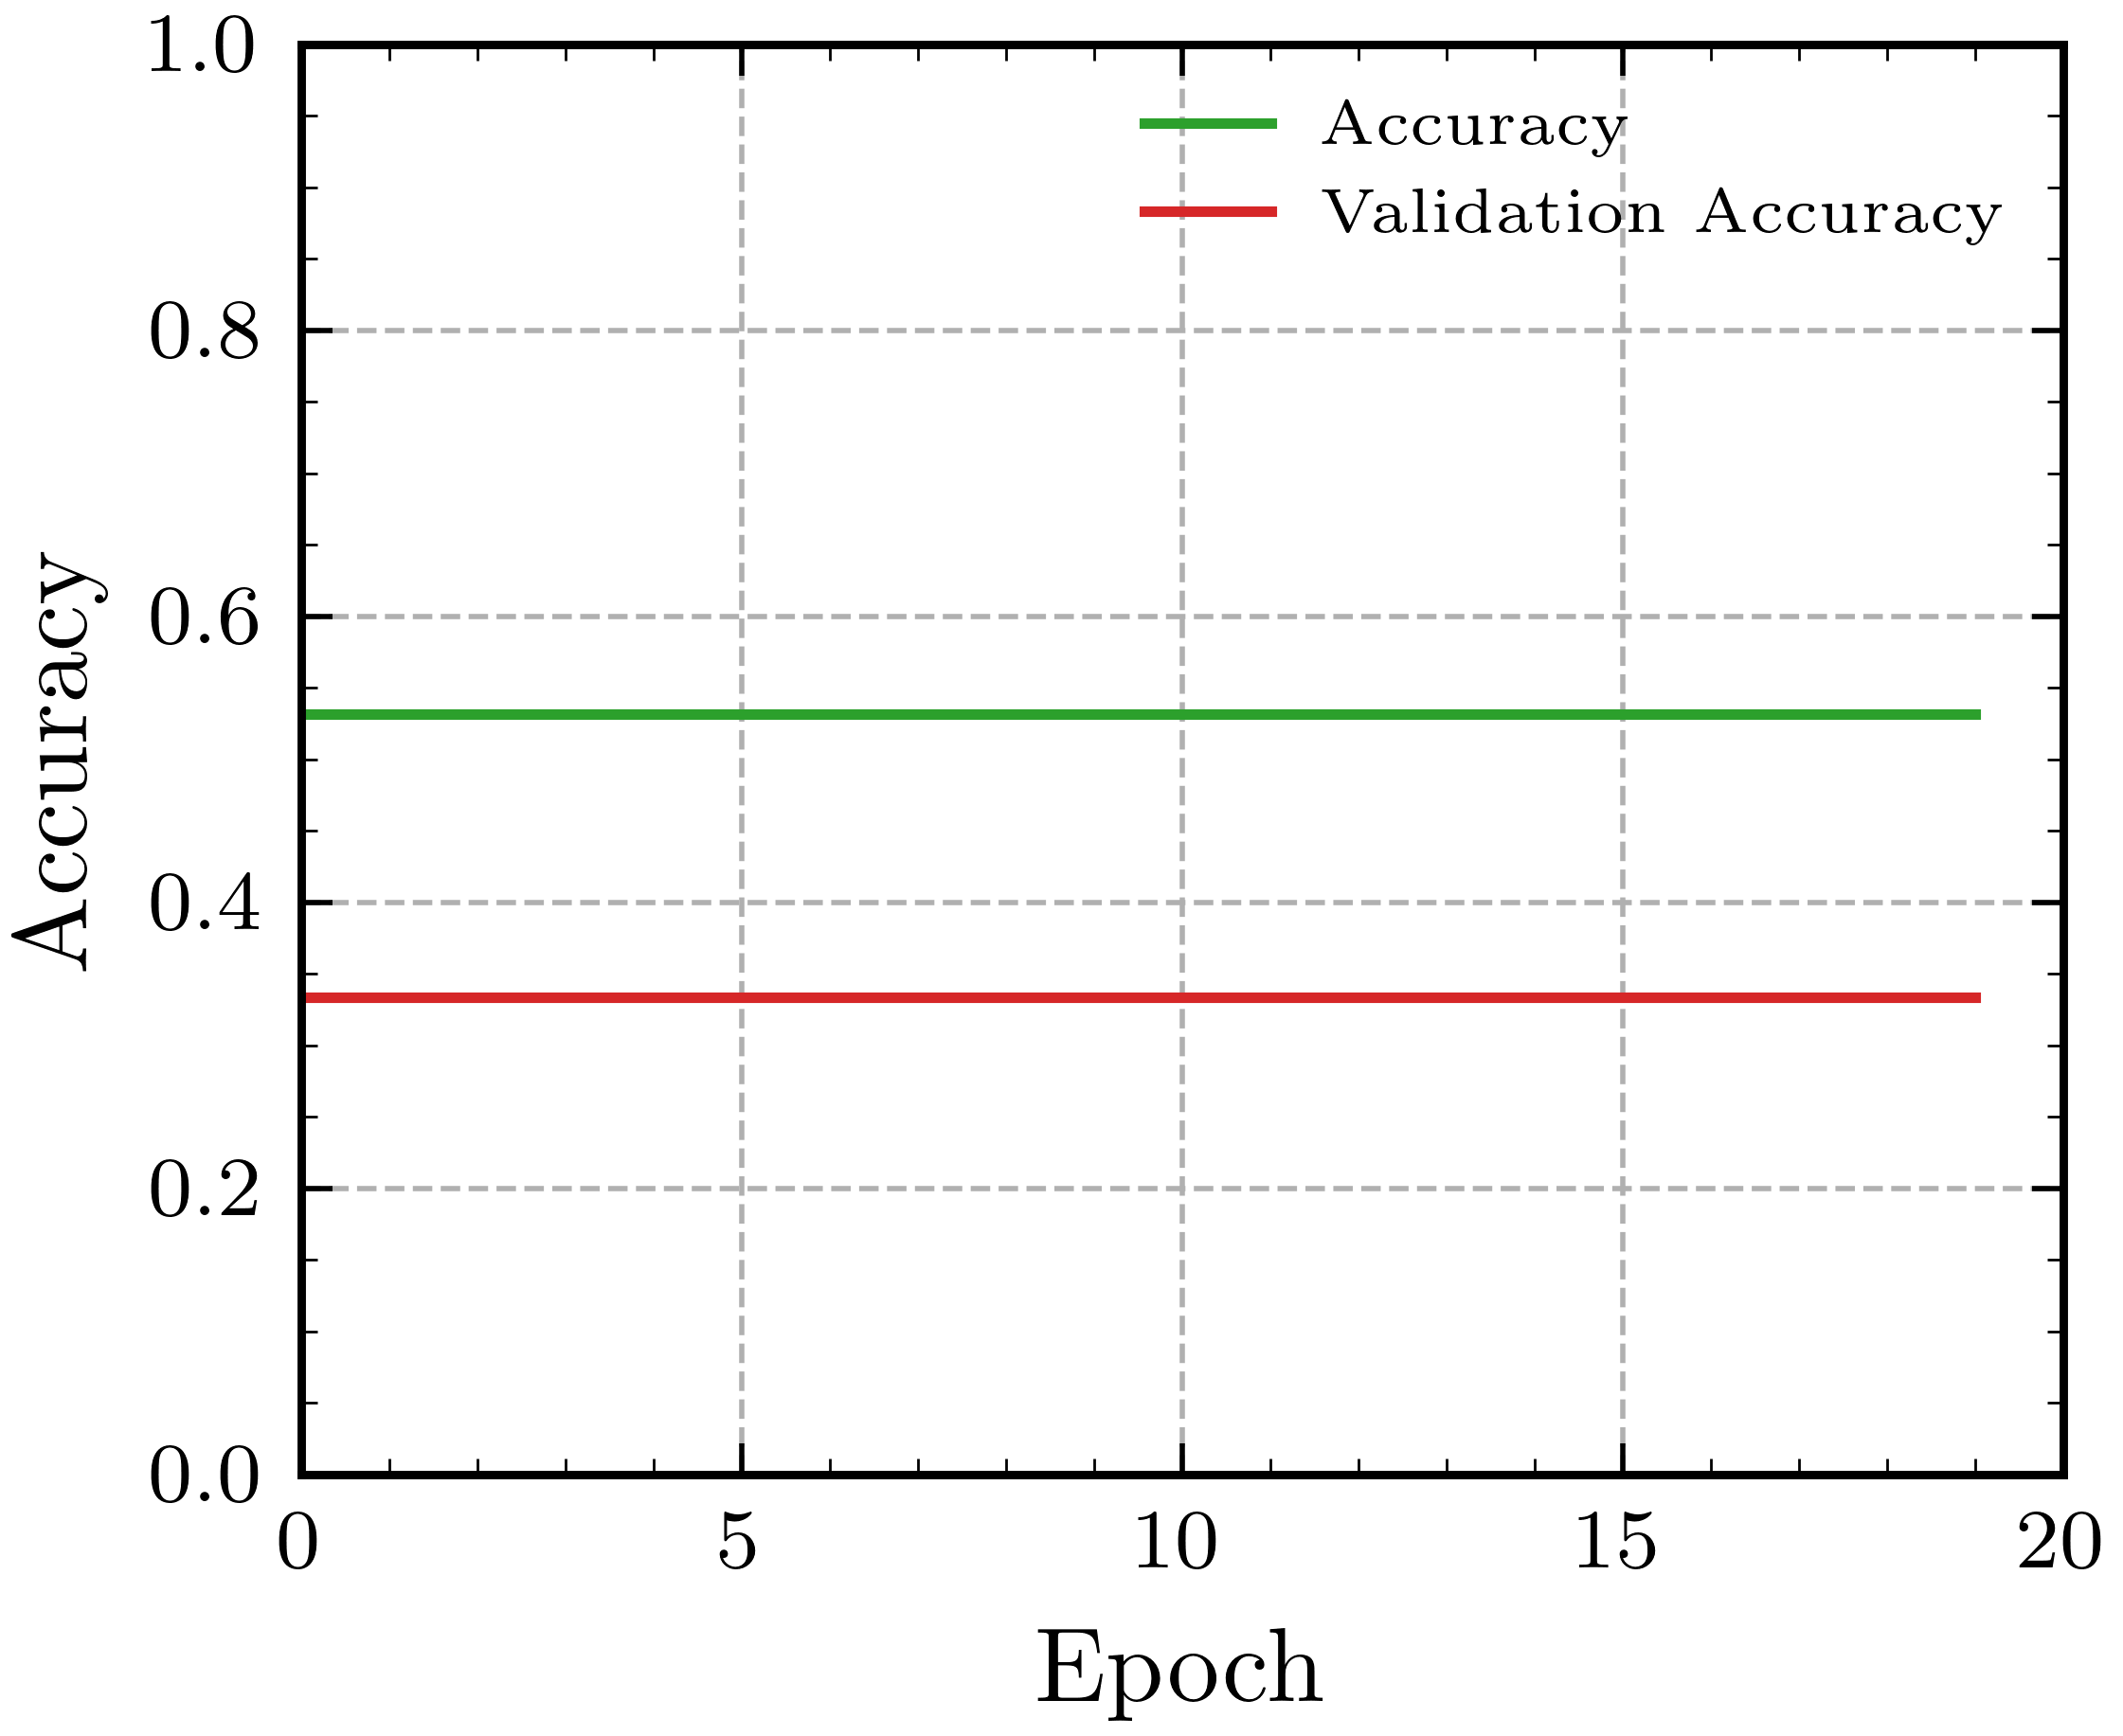

In [46]:
fig = plt.figure(facecolor='white')
gs = fig.add_gridspec(ncols=1, nrows=1, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)

ax.label_outer()
ax.tick_params(which='both', direction="in")
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', lw=.5)
ax.minorticks_on()
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_xlim(0, N_EPOCHS['cmes'])
ax.set_ylim(0, 1)

ax.plot(history.history['accuracy'], color='tab:green',
        ls='-', lw=1, label='Accuracy')
ax.plot(history.history['val_accuracy'], color='tab:red',
        ls='-', lw=1, label='Validation Accuracy')

ax.legend(loc='upper right', framealpha=0)
fig.savefig('../images/tp1_fig4.pdf')
plt.show()

## Classification and Validation

In [47]:
y_pred = model.predict(feats_test)

1/1 [==============================] - 0s 53ms/step


In [48]:
cm = confusion_matrix(np.round(y_pred),
                      target_test,
                      labels=[0., 1.])

In [49]:
# Confusion matrix structure
# TN | FP
# FN | TP

print(cm)

[[6 5]
 [0 0]]


In [50]:
# print(np.diag(cm).sum() / cm.sum())
print(accuracy_score(target_test, np.round(y_pred)))

0.5454545454545454
